In [1]:
import networkx as nx
import numpy as np
import torch
from model import CaT
import inference
import pandas as pd
import matplotlib.pyplot as plt
from datasets import get_full_ordering, reorder_dag

shuffling = 0
seed = 1
standardize = 0
sample_size = 10000
batch_size = 100
max_iters = 100000
eval_interval = 100
eval_iters = 100
validation_fraction = 0.3
np.random.seed(seed=seed)
torch.manual_seed(seed)
device = 'cuda'
dropout_rate = 0.0
learning_rate = 5e-3
ff_n_embed = 6
num_heads = 1
n_layers = 1
head_size = 6
d = 5

def generate_data(N, d=5):
    DAGnx = nx.DiGraph()
    
    Ux = np.random.randn(N,d)
    X =  Ux
    
    Ub = np.random.randn(N,d)
    B =  Ub
    
    Uc = np.random.randn(N,d)
    C =  Uc
    
    Uy = np.random.randn(N,d)
    Y = X + B + C + 0.1 * Uy

    Y0 = B + C
    Y1 = 1 + B + C

    all_data_dict = {'X': X, 'B': B, 'C': C, 'Y': Y}

    # types can be 'cat' (categorical) 'cont' (continuous) or 'bin' (binary)
    var_types = {'X': 'cont', 'B': 'cont', 'C': 'cont', 'Y': 'cont'}

    DAGnx.add_edges_from([('X', 'Y'), ('B', 'Y'), ('C', 'Y')])
    DAGnx = reorder_dag(dag=DAGnx)  # topologically sorted dag
    var_names = list(DAGnx.nodes())  # topologically ordered list of variables
    all_data = np.stack([all_data_dict[key] for key in var_names], axis=1)
    causal_ordering = get_full_ordering(DAGnx)

    return all_data, DAGnx, var_names, causal_ordering, var_types, Y0, Y1


def generate_data_mediation(N, d=5):
    DAGnx = nx.DiGraph()
    
    Ux = np.random.randn(N,d)
    X =  Ux

    Um = np.random.randn(N,d)
    M =  0.5 * X + Um

    Uy = np.random.randn(N,d)
    Y =  0.5 * M + 0.1 * Uy

    M0 = 0.5 * 0 + Um 
    M1 = 0.5 * 1 + Um

    Y0 = 0.5 * M0 + 0.1 * Uy 
    Y1 = 0.5 * M1 + 0.1 * Uy 

    all_data_dict = {'X': X, 'M': M, 'Y': Y}

    # types can be 'cat' (categorical) 'cont' (continuous) or 'bin' (binary)
    var_types = {'X': 'cont', 'M': 'cont', 'Y': 'cont'}

    DAGnx.add_edges_from([('X', 'M'), ('M', 'Y')])
    DAGnx = reorder_dag(dag=DAGnx)  # topologically sorted dag
    var_names = list(DAGnx.nodes())  # topologically ordered list of variables
    all_data = np.stack([all_data_dict[key] for key in var_names], axis=1)
    causal_ordering = get_full_ordering(DAGnx)

    return all_data, DAGnx, var_names, causal_ordering, var_types, Y0, Y1

## Exogenous Example

In [2]:
d=3
_, _, _, _, _, Y0, Y1 = generate_data(N=1000000, d=d)
ATE = (Y1 - Y0).mean(0)  # multi-dim ATE based off a large sample
all_data, DAGnx, var_names, causal_ordering, var_types, Y0, Y1 = generate_data(N=sample_size, d=d)
print(var_names, ATE)
print(all_data.shape)

indices = np.arange(0, len(all_data))
np.random.shuffle(indices)

val_inds = indices[:int(validation_fraction*len(indices))]
train_inds = indices[int(validation_fraction*len(indices)):]
train_data = all_data[train_inds]
val_data = all_data[val_inds]
train_data, val_data = torch.from_numpy(train_data).float(),  torch.from_numpy(val_data).float()

['X', 'B', 'C', 'Y'] [1. 1. 1.]
(10000, 4, 3)


In [3]:
input_dim = all_data.shape[2]

model = CaT(input_dim=input_dim,
                dropout_rate=dropout_rate,
                head_size=head_size,
                num_heads=num_heads,
                ff_n_embed=ff_n_embed,
                dag=DAGnx,
                causal_ordering=causal_ordering,
                n_layers=n_layers,
                device=device,
                var_types_sorted=var_types,
                ).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [4]:
def get_batch(train_data, val_data, split, device, batch_size):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(0, len(data), (batch_size,))
    x = data[ix]
    return x.to(device)

all_var_losses = {}
for iter_ in range(0, max_iters):
    # train and update the model
    model.train()

    xb = get_batch(train_data=train_data, val_data=val_data, split='train', device=device, batch_size=batch_size)
    xb_mod = torch.clone(xb.detach())
    X, loss, loss_dict = model(X=xb, targets=xb_mod, shuffling=shuffling)

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()


    if iter_ % eval_interval == 0:  # evaluate the loss (no gradients)
        for key in loss_dict.keys():
            if key not in all_var_losses.keys():
                all_var_losses[key] = []
            all_var_losses[key].append(loss_dict[key])

        model.eval()
        eval_loss = {}
        for split in ['train', 'val']:
            losses = torch.zeros(eval_iters)
            for k in range(eval_iters):

                xb = get_batch(train_data=train_data, val_data=val_data, split=split, device=device,
                               batch_size=batch_size)
                xb_mod = torch.clone(xb.detach())
                X, loss, loss_dict = model(X=xb, targets=xb_mod, shuffling=False)
                losses[k] = loss.item()
            eval_loss[split] = losses.mean()
        model.train()
        print(f"step {iter_} of {max_iters}: train_loss {eval_loss['train']:.4f}, val loss {eval_loss['val']:.4f}")

step 0 of 100000: train_loss 3.4988, val loss 3.4819
step 100 of 100000: train_loss 1.7980, val loss 1.7560
step 200 of 100000: train_loss 1.0250, val loss 0.9920
step 300 of 100000: train_loss 1.0055, val loss 0.9417
step 400 of 100000: train_loss 0.2804, val loss 0.2744
step 500 of 100000: train_loss 0.2135, val loss 0.2073
step 600 of 100000: train_loss 0.1361, val loss 0.1427
step 700 of 100000: train_loss 0.0683, val loss 0.0700
step 800 of 100000: train_loss 0.0367, val loss 0.0351
step 900 of 100000: train_loss 0.0283, val loss 0.0292
step 1000 of 100000: train_loss 0.0258, val loss 0.0247
step 1100 of 100000: train_loss 0.0232, val loss 0.0238
step 1200 of 100000: train_loss 0.0227, val loss 0.0222
step 1300 of 100000: train_loss 0.0198, val loss 0.0194
step 1400 of 100000: train_loss 0.0185, val loss 0.0190
step 1500 of 100000: train_loss 0.0175, val loss 0.0175
step 1600 of 100000: train_loss 0.0186, val loss 0.0176
step 1700 of 100000: train_loss 0.0174, val loss 0.0170
step

step 14600 of 100000: train_loss 0.0129, val loss 0.0131
step 14700 of 100000: train_loss 0.0126, val loss 0.0130
step 14800 of 100000: train_loss 0.0124, val loss 0.0127
step 14900 of 100000: train_loss 0.0124, val loss 0.0129
step 15000 of 100000: train_loss 0.0126, val loss 0.0128
step 15100 of 100000: train_loss 0.0122, val loss 0.0126
step 15200 of 100000: train_loss 0.0119, val loss 0.0121
step 15300 of 100000: train_loss 0.0133, val loss 0.0140
step 15400 of 100000: train_loss 0.0126, val loss 0.0127
step 15500 of 100000: train_loss 0.0139, val loss 0.0145
step 15600 of 100000: train_loss 0.0127, val loss 0.0135
step 15700 of 100000: train_loss 0.0132, val loss 0.0138
step 15800 of 100000: train_loss 0.0120, val loss 0.0123
step 15900 of 100000: train_loss 0.0130, val loss 0.0133
step 16000 of 100000: train_loss 0.0122, val loss 0.0121
step 16100 of 100000: train_loss 0.0143, val loss 0.0149
step 16200 of 100000: train_loss 0.0121, val loss 0.0126
step 16300 of 100000: train_los

step 29000 of 100000: train_loss 0.0121, val loss 0.0126
step 29100 of 100000: train_loss 0.0122, val loss 0.0127
step 29200 of 100000: train_loss 0.0163, val loss 0.0171
step 29300 of 100000: train_loss 0.0122, val loss 0.0123
step 29400 of 100000: train_loss 0.0137, val loss 0.0140
step 29500 of 100000: train_loss 0.0118, val loss 0.0126
step 29600 of 100000: train_loss 0.0133, val loss 0.0138
step 29700 of 100000: train_loss 0.0122, val loss 0.0126
step 29800 of 100000: train_loss 0.0139, val loss 0.0149
step 29900 of 100000: train_loss 0.0127, val loss 0.0129
step 30000 of 100000: train_loss 0.0123, val loss 0.0131
step 30100 of 100000: train_loss 0.0122, val loss 0.0124
step 30200 of 100000: train_loss 0.0119, val loss 0.0124
step 30300 of 100000: train_loss 0.0141, val loss 0.0144
step 30400 of 100000: train_loss 0.0132, val loss 0.0138
step 30500 of 100000: train_loss 0.0124, val loss 0.0131
step 30600 of 100000: train_loss 0.0121, val loss 0.0126
step 30700 of 100000: train_los

step 43400 of 100000: train_loss 0.0128, val loss 0.0130
step 43500 of 100000: train_loss 0.0123, val loss 0.0129
step 43600 of 100000: train_loss 0.0124, val loss 0.0130
step 43700 of 100000: train_loss 0.0129, val loss 0.0139
step 43800 of 100000: train_loss 0.0126, val loss 0.0132
step 43900 of 100000: train_loss 0.0120, val loss 0.0121
step 44000 of 100000: train_loss 0.0143, val loss 0.0150
step 44100 of 100000: train_loss 0.0118, val loss 0.0127
step 44200 of 100000: train_loss 0.0123, val loss 0.0133
step 44300 of 100000: train_loss 0.0122, val loss 0.0127
step 44400 of 100000: train_loss 0.0124, val loss 0.0128
step 44500 of 100000: train_loss 0.0138, val loss 0.0148
step 44600 of 100000: train_loss 0.0149, val loss 0.0152
step 44700 of 100000: train_loss 0.0138, val loss 0.0146
step 44800 of 100000: train_loss 0.0139, val loss 0.0151
step 44900 of 100000: train_loss 0.0120, val loss 0.0127
step 45000 of 100000: train_loss 0.0129, val loss 0.0137
step 45100 of 100000: train_los

step 57800 of 100000: train_loss 0.0128, val loss 0.0135
step 57900 of 100000: train_loss 0.0123, val loss 0.0132
step 58000 of 100000: train_loss 0.0141, val loss 0.0141
step 58100 of 100000: train_loss 0.0128, val loss 0.0130
step 58200 of 100000: train_loss 0.0122, val loss 0.0128
step 58300 of 100000: train_loss 0.0121, val loss 0.0124
step 58400 of 100000: train_loss 0.0126, val loss 0.0135
step 58500 of 100000: train_loss 0.0118, val loss 0.0125
step 58600 of 100000: train_loss 0.0131, val loss 0.0140
step 58700 of 100000: train_loss 0.0128, val loss 0.0133
step 58800 of 100000: train_loss 0.0126, val loss 0.0131
step 58900 of 100000: train_loss 0.0124, val loss 0.0131
step 59000 of 100000: train_loss 0.0148, val loss 0.0152
step 59100 of 100000: train_loss 0.0122, val loss 0.0125
step 59200 of 100000: train_loss 0.0117, val loss 0.0124
step 59300 of 100000: train_loss 0.0128, val loss 0.0133
step 59400 of 100000: train_loss 0.0118, val loss 0.0120
step 59500 of 100000: train_los

step 72200 of 100000: train_loss 0.0118, val loss 0.0125
step 72300 of 100000: train_loss 0.0122, val loss 0.0130
step 72400 of 100000: train_loss 0.0132, val loss 0.0140
step 72500 of 100000: train_loss 0.0132, val loss 0.0137
step 72600 of 100000: train_loss 0.0126, val loss 0.0131
step 72700 of 100000: train_loss 0.0132, val loss 0.0140
step 72800 of 100000: train_loss 0.0121, val loss 0.0125
step 72900 of 100000: train_loss 0.0131, val loss 0.0137
step 73000 of 100000: train_loss 0.0122, val loss 0.0128
step 73100 of 100000: train_loss 0.0123, val loss 0.0127
step 73200 of 100000: train_loss 0.0139, val loss 0.0147
step 73300 of 100000: train_loss 0.0128, val loss 0.0134
step 73400 of 100000: train_loss 0.0119, val loss 0.0129
step 73500 of 100000: train_loss 0.0117, val loss 0.0121
step 73600 of 100000: train_loss 0.0119, val loss 0.0125
step 73700 of 100000: train_loss 0.0121, val loss 0.0126
step 73800 of 100000: train_loss 0.0121, val loss 0.0127
step 73900 of 100000: train_los

step 86600 of 100000: train_loss 0.0120, val loss 0.0127
step 86700 of 100000: train_loss 0.0133, val loss 0.0139
step 86800 of 100000: train_loss 0.0125, val loss 0.0130
step 86900 of 100000: train_loss 0.0129, val loss 0.0131
step 87000 of 100000: train_loss 0.0122, val loss 0.0128
step 87100 of 100000: train_loss 0.0120, val loss 0.0127
step 87200 of 100000: train_loss 0.0131, val loss 0.0134
step 87300 of 100000: train_loss 0.0122, val loss 0.0129
step 87400 of 100000: train_loss 0.0115, val loss 0.0121
step 87500 of 100000: train_loss 0.0133, val loss 0.0136
step 87600 of 100000: train_loss 0.0119, val loss 0.0123
step 87700 of 100000: train_loss 0.0118, val loss 0.0126
step 87800 of 100000: train_loss 0.0124, val loss 0.0129
step 87900 of 100000: train_loss 0.0137, val loss 0.0142
step 88000 of 100000: train_loss 0.0123, val loss 0.0130
step 88100 of 100000: train_loss 0.0127, val loss 0.0131
step 88200 of 100000: train_loss 0.0140, val loss 0.0144
step 88300 of 100000: train_los

ATE: [1. 1. 1.] est ATE: [0.98952744 1.02514063 1.02447   ] error: [0.01047256 0.02514063 0.02447   ]


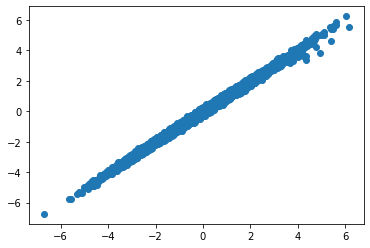

In [7]:
model.eval()
inf = inference.CausalInference(model=model, device=device)

int_nodes_vals0 = {'X':np.array([0.0,])}
int_nodes_vals1 = {'X':np.array([1.0,])}
effect_var = 'Y'
effect_index = var_names.index(effect_var)

preds0 = inf.forward(all_data, int_nodes_vals0)
preds1 = inf.forward(all_data, int_nodes_vals1)
ATE_pred = (preds1[:,effect_index,:] - preds0[:,effect_index,:]).mean(0)
eATE = np.abs(ATE_pred - ATE)
print('ATE:', ATE, 'est ATE:', ATE_pred, 'error:', eATE)

preds = model(train_data.to(device))

plt.scatter(train_data[:,effect_index,-1].detach().cpu().numpy(), preds[:, effect_index, -1].detach().cpu().numpy())

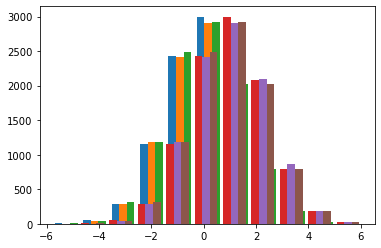

(array([1.300e+01, 1.170e+02, 9.140e+02, 2.787e+03, 3.690e+03, 1.917e+03,
        4.950e+02, 6.500e+01, 1.000e+00, 1.000e+00]),
 array([-4.75669575, -3.42283726, -2.08897877, -0.75512028,  0.57873821,
         1.9125967 ,  3.24645519,  4.58031368,  5.91417217,  7.24803066,
         8.58188915]),
 <BarContainer object of 10 artists>)

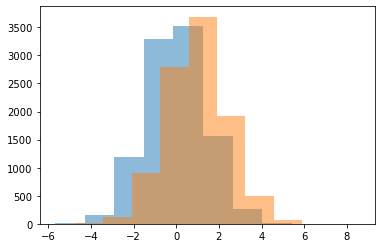

In [8]:

plt.hist(preds0[:,3, 0], alpha=0.5)
plt.hist(preds1[:,3, 0], alpha=0.5)
plt.show()

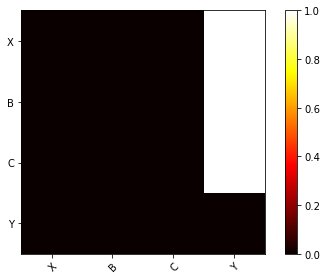

In [10]:
# view attention maps
maps = []
for j in range(n_layers):
    heads = model.blocks[j].mha.heads
    for i in range(num_heads):
        maps.append(heads[i].att_wei.mean(0).cpu().detach().numpy())

maps = np.stack(maps).mean(0)

fig, ax = plt.subplots()
im = ax.imshow(maps, cmap='hot', interpolation='nearest')
cbar = ax.figure.colorbar(im, ax=ax, shrink=1)
# Setting the axis tick labels
ax.set_xticks(np.arange(len(list(DAGnx.nodes))))
ax.set_yticks(np.arange(len(list(DAGnx.nodes))))

ax.set_xticklabels(list(DAGnx.nodes))
ax.set_yticklabels(list(DAGnx.nodes))

# Rotating the tick labels inorder to set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

fig.tight_layout()
plt.savefig('attention_maps.png')


## Mediation Example

In [7]:
d=3
_, _, _, _, _, Y0, Y1 = generate_data_mediation(N=1000000, d=d)
ATE = (Y1 - Y0).mean(0)  # multi-dim ATE based off a large sample
all_data, DAGnx, var_names, causal_ordering, var_types, Y0, Y1 = generate_data_mediation(N=sample_size, d=d)
print(var_names, ATE)
print(all_data.shape)

indices = np.arange(0, len(all_data))
np.random.shuffle(indices)

val_inds = indices[:int(validation_fraction*len(indices))]
train_inds = indices[int(validation_fraction*len(indices)):]
train_data = all_data[train_inds]
val_data = all_data[val_inds]
train_data, val_data = torch.from_numpy(train_data).float(),  torch.from_numpy(val_data).float()

['X', 'M', 'Y'] [0.25 0.25 0.25]
(10000, 3, 3)


In [8]:
input_dim = all_data.shape[2]

model = CaT(input_dim=input_dim,
                dropout_rate=dropout_rate,
                head_size=head_size,
                num_heads=num_heads,
                ff_n_embed=ff_n_embed,
                dag=DAGnx,
                causal_ordering=causal_ordering,
                n_layers=n_layers,
                device=device,
                var_types_sorted=var_types,
                ).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [9]:
def get_batch(train_data, val_data, split, device, batch_size):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(0, len(data), (batch_size,))
    x = data[ix]
    return x.to(device)

all_var_losses = {}
for iter_ in range(0, max_iters):
    # train and update the model
    model.train()

    xb = get_batch(train_data=train_data, val_data=val_data, split='train', device=device, batch_size=batch_size)
    xb_mod = torch.clone(xb.detach())
    X, loss, loss_dict = model(X=xb, targets=xb_mod, shuffling=shuffling)

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()


    if iter_ % eval_interval == 0:  # evaluate the loss (no gradients)
        for key in loss_dict.keys():
            if key not in all_var_losses.keys():
                all_var_losses[key] = []
            all_var_losses[key].append(loss_dict[key])

        model.eval()
        eval_loss = {}
        for split in ['train', 'val']:
            losses = torch.zeros(eval_iters)
            for k in range(eval_iters):

                xb = get_batch(train_data=train_data, val_data=val_data, split=split, device=device,
                               batch_size=batch_size)
                xb_mod = torch.clone(xb.detach())
                X, loss, loss_dict = model(X=xb, targets=xb_mod, shuffling=False)
                losses[k] = loss.item()
            eval_loss[split] = losses.mean()
        model.train()
        print(f"step {iter_} of {max_iters}: train_loss {eval_loss['train']:.4f}, val loss {eval_loss['val']:.4f}")
    

step 0 of 100000: train_loss 2.5349, val loss 2.4913
step 100 of 100000: train_loss 2.2544, val loss 2.2282
step 200 of 100000: train_loss 2.0964, val loss 2.0861
step 300 of 100000: train_loss 2.0538, val loss 2.0514
step 400 of 100000: train_loss 2.0400, val loss 2.0190
step 500 of 100000: train_loss 2.0294, val loss 2.0311
step 600 of 100000: train_loss 2.0253, val loss 2.0141
step 700 of 100000: train_loss 2.0548, val loss 2.0068
step 800 of 100000: train_loss 2.0317, val loss 2.0219
step 900 of 100000: train_loss 2.0319, val loss 2.0376
step 1000 of 100000: train_loss 2.0153, val loss 2.0021
step 1100 of 100000: train_loss 2.0224, val loss 2.0200
step 1200 of 100000: train_loss 2.0125, val loss 2.0134
step 1300 of 100000: train_loss 2.0322, val loss 2.0134
step 1400 of 100000: train_loss 2.0064, val loss 2.0309
step 1500 of 100000: train_loss 2.0065, val loss 2.0054
step 1600 of 100000: train_loss 2.0270, val loss 2.0112
step 1700 of 100000: train_loss 2.0252, val loss 2.0016
step

step 14600 of 100000: train_loss 2.0208, val loss 2.0133
step 14700 of 100000: train_loss 2.0081, val loss 2.0136
step 14800 of 100000: train_loss 2.0161, val loss 2.0166
step 14900 of 100000: train_loss 2.0155, val loss 1.9956
step 15000 of 100000: train_loss 2.0125, val loss 2.0126
step 15100 of 100000: train_loss 2.0233, val loss 2.0154
step 15200 of 100000: train_loss 2.0146, val loss 1.9905
step 15300 of 100000: train_loss 2.0097, val loss 2.0055
step 15400 of 100000: train_loss 2.0236, val loss 2.0288
step 15500 of 100000: train_loss 2.0236, val loss 1.9940
step 15600 of 100000: train_loss 2.0004, val loss 2.0122
step 15700 of 100000: train_loss 2.0463, val loss 2.0075
step 15800 of 100000: train_loss 2.0173, val loss 1.9942
step 15900 of 100000: train_loss 2.0056, val loss 2.0173
step 16000 of 100000: train_loss 2.0072, val loss 2.0022
step 16100 of 100000: train_loss 1.9933, val loss 1.9943
step 16200 of 100000: train_loss 2.0218, val loss 2.0131
step 16300 of 100000: train_los

step 29000 of 100000: train_loss 2.0093, val loss 1.9925
step 29100 of 100000: train_loss 2.0064, val loss 2.0138
step 29200 of 100000: train_loss 2.0136, val loss 2.0162
step 29300 of 100000: train_loss 2.0185, val loss 2.0090
step 29400 of 100000: train_loss 2.0177, val loss 2.0023
step 29500 of 100000: train_loss 2.0074, val loss 2.0031
step 29600 of 100000: train_loss 2.0427, val loss 2.0172
step 29700 of 100000: train_loss 2.0260, val loss 1.9842
step 29800 of 100000: train_loss 2.0348, val loss 1.9975
step 29900 of 100000: train_loss 2.0060, val loss 2.0225
step 30000 of 100000: train_loss 2.0227, val loss 2.0028
step 30100 of 100000: train_loss 2.0387, val loss 1.9922
step 30200 of 100000: train_loss 2.0175, val loss 1.9904
step 30300 of 100000: train_loss 2.0191, val loss 2.0154
step 30400 of 100000: train_loss 2.0003, val loss 2.0100
step 30500 of 100000: train_loss 2.0092, val loss 2.0282
step 30600 of 100000: train_loss 2.0109, val loss 2.0042
step 30700 of 100000: train_los

step 43400 of 100000: train_loss 2.0130, val loss 2.0100
step 43500 of 100000: train_loss 1.9999, val loss 2.0065
step 43600 of 100000: train_loss 2.0133, val loss 2.0020
step 43700 of 100000: train_loss 2.0255, val loss 2.0029
step 43800 of 100000: train_loss 2.0180, val loss 2.0102
step 43900 of 100000: train_loss 2.0207, val loss 2.0011
step 44000 of 100000: train_loss 2.0223, val loss 2.0151
step 44100 of 100000: train_loss 2.0108, val loss 2.0060
step 44200 of 100000: train_loss 2.0096, val loss 2.0131
step 44300 of 100000: train_loss 2.0168, val loss 2.0032
step 44400 of 100000: train_loss 2.0026, val loss 2.0039
step 44500 of 100000: train_loss 2.0129, val loss 2.0122
step 44600 of 100000: train_loss 2.0392, val loss 1.9920
step 44700 of 100000: train_loss 2.0100, val loss 1.9896
step 44800 of 100000: train_loss 2.0274, val loss 1.9873
step 44900 of 100000: train_loss 2.0329, val loss 2.0149
step 45000 of 100000: train_loss 1.9935, val loss 2.0152
step 45100 of 100000: train_los

step 57800 of 100000: train_loss 2.0135, val loss 1.9869
step 57900 of 100000: train_loss 2.0424, val loss 1.9962
step 58000 of 100000: train_loss 2.0076, val loss 2.0132
step 58100 of 100000: train_loss 2.0059, val loss 2.0066
step 58200 of 100000: train_loss 2.0235, val loss 1.9869
step 58300 of 100000: train_loss 2.0002, val loss 2.0098
step 58400 of 100000: train_loss 2.0154, val loss 2.0231
step 58500 of 100000: train_loss 2.0082, val loss 1.9995
step 58600 of 100000: train_loss 2.0227, val loss 1.9878
step 58700 of 100000: train_loss 2.0229, val loss 2.0211
step 58800 of 100000: train_loss 2.0181, val loss 2.0104
step 58900 of 100000: train_loss 2.0113, val loss 2.0228
step 59000 of 100000: train_loss 2.0226, val loss 2.0068
step 59100 of 100000: train_loss 2.0331, val loss 2.0057
step 59200 of 100000: train_loss 2.0296, val loss 1.9907
step 59300 of 100000: train_loss 2.0298, val loss 2.0097
step 59400 of 100000: train_loss 2.0251, val loss 2.0040
step 59500 of 100000: train_los

step 72200 of 100000: train_loss 2.0262, val loss 2.0001
step 72300 of 100000: train_loss 2.0273, val loss 1.9892
step 72400 of 100000: train_loss 2.0100, val loss 1.9978
step 72500 of 100000: train_loss 2.0322, val loss 2.0037
step 72600 of 100000: train_loss 2.0289, val loss 1.9866
step 72700 of 100000: train_loss 2.0085, val loss 2.0032
step 72800 of 100000: train_loss 2.0114, val loss 1.9888
step 72900 of 100000: train_loss 2.0216, val loss 2.0131
step 73000 of 100000: train_loss 2.0364, val loss 2.0242
step 73100 of 100000: train_loss 2.0032, val loss 1.9918
step 73200 of 100000: train_loss 2.0399, val loss 2.0162
step 73300 of 100000: train_loss 2.0117, val loss 2.0193
step 73400 of 100000: train_loss 2.0199, val loss 2.0168
step 73500 of 100000: train_loss 2.0210, val loss 2.0011
step 73600 of 100000: train_loss 2.0019, val loss 2.0090
step 73700 of 100000: train_loss 2.0031, val loss 2.0020
step 73800 of 100000: train_loss 2.0356, val loss 1.9897
step 73900 of 100000: train_los

step 86600 of 100000: train_loss 2.0287, val loss 1.9921
step 86700 of 100000: train_loss 2.0180, val loss 1.9931
step 86800 of 100000: train_loss 2.0078, val loss 2.0104
step 86900 of 100000: train_loss 2.0165, val loss 1.9942
step 87000 of 100000: train_loss 2.0046, val loss 2.0112
step 87100 of 100000: train_loss 2.0109, val loss 1.9840
step 87200 of 100000: train_loss 2.0237, val loss 1.9984
step 87300 of 100000: train_loss 2.0186, val loss 2.0226
step 87400 of 100000: train_loss 2.0151, val loss 2.0060
step 87500 of 100000: train_loss 1.9923, val loss 1.9847
step 87600 of 100000: train_loss 2.0231, val loss 2.0148
step 87700 of 100000: train_loss 2.0079, val loss 2.0058
step 87800 of 100000: train_loss 2.0042, val loss 2.0111
step 87900 of 100000: train_loss 2.0031, val loss 2.0156
step 88000 of 100000: train_loss 2.0293, val loss 2.0136
step 88100 of 100000: train_loss 2.0203, val loss 2.0024
step 88200 of 100000: train_loss 1.9946, val loss 2.0141
step 88300 of 100000: train_los

ATE: [0.25 0.25 0.25] est ATE: [0.2242581  0.20168029 0.23853552] error: [0.0257419  0.04831971 0.01146448]


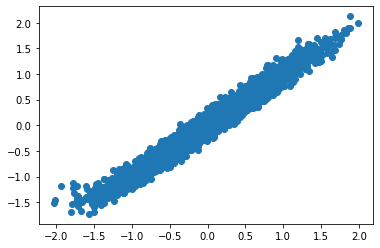

In [12]:
model.eval()
inf = inference.CausalInference(model=model, device=device)

int_nodes_vals0 = {'X':np.array([0.0,])}
int_nodes_vals1 = {'X':np.array([1.0,])}
effect_var = 'Y'
effect_index = var_names.index(effect_var)

preds0 = inf.forward(all_data, int_nodes_vals0)
preds1 = inf.forward(all_data, int_nodes_vals1)
ATE_pred = (preds1[:,effect_index,:] - preds0[:,effect_index,:]).mean(0)
eATE = np.abs(ATE_pred - ATE)
print('ATE:', ATE, 'est ATE:', ATE_pred, 'error:', eATE)

preds = model(train_data.to(device))

plt.scatter(train_data[:,effect_index,-1].detach().cpu().numpy(), preds[:, effect_index, -1].detach().cpu().numpy())

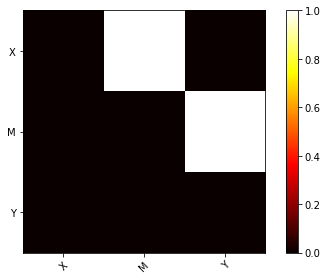

In [13]:
# view attention maps
maps = []
for j in range(n_layers):
    heads = model.blocks[j].mha.heads
    for i in range(num_heads):
        maps.append(heads[i].att_wei.mean(0).cpu().detach().numpy())

maps = np.stack(maps).mean(0)

fig, ax = plt.subplots()
im = ax.imshow(maps, cmap='hot', interpolation='nearest')
cbar = ax.figure.colorbar(im, ax=ax, shrink=1)
# Setting the axis tick labels
ax.set_xticks(np.arange(len(list(DAGnx.nodes))))
ax.set_yticks(np.arange(len(list(DAGnx.nodes))))

ax.set_xticklabels(list(DAGnx.nodes))
ax.set_yticklabels(list(DAGnx.nodes))

# Rotating the tick labels inorder to set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

fig.tight_layout()
plt.savefig('attention_maps.png')
